In [44]:
from transformers import CLIPProcessor, CLIPModel
import os
from PIL import Image
from torch.nn.functional import cosine_similarity
import torch
import numpy as np
from IPython.display import HTML, display
import base64
from tqdm import tqdm
import pandas as pd


In [5]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

In [26]:
def calculate_similarity(image_paths, texts):
    with torch.no_grad():
        # Calculate similarity
        inputs = processor(text=texts, return_tensors="pt", padding=True, truncation=True)
        text_embeddings = model.get_text_features(**inputs)

        # Load and process the images
        images = [Image.open(image_path).convert("RGB") for image_path in image_paths]
        inputs = processor(images=images, return_tensors="pt")
        image_embeddings = model.get_image_features(**inputs)
    
        # Calculate the similarity (the result is a matrix of text x image similarities. Images on the rows, text on the columns)
        similarity_matrix = cosine_similarity(image_embeddings.unsqueeze(1), text_embeddings.unsqueeze(0), dim = 2)
    
    return similarity_matrix

In [80]:
def image_to_data_uri(img_path):
    """
    Converts an image to a data URI for embedding directly in HTML.
    """
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def display_similarity(image_paths, texts, real_age):
    # Start with the table header, adding styles for center alignment
    similarity_matrix = calculate_similarity(image_paths, texts)
    similarity_matrix.min(), similarity_matrix.max()

    # Use numpy to do similarity match
    similarity_matrix_np = similarity_matrix.detach().numpy()


    html = """
    <table border="1" style="border-collapse: collapse; width: 100%;">
    <tr>
    <th style="text-align: center; vertical-align: middle;">Фото человека</th>
    <th style="text-align: center; vertical-align: middle;">Его предполагаемый возраст</th>
    <th style="text-align: center; vertical-align: middle;">Его реальный возраст</th>
    </tr>
    """

    # Fill the table rows with your data
    for i, img_path in enumerate(image_paths):
        img_data_uri = "data:image/jpeg;base64," + image_to_data_uri(img_path)
        # Convert the row of similarity scores
        similarities = similarity_matrix_np[i, :]
        # Find the index of the best matching text (highest similarity)
        best_match_index = np.argmax(similarities)
        best_matched_text = texts[best_match_index]


        html += f"<tr><td style='text-align: center; vertical-align: middle;'><img src='{img_data_uri}' width='100'></td>"
        html += f"<td style='text-align: center; vertical-align: middle;'><b>{best_matched_text}</b></td>"
        html += f"<td style='text-align: center; vertical-align: middle;'><b>{real_age[i]}</b></td></tr></tr>"

    html += "</table>"
        
    display(HTML(html))
    

In [81]:
def get_image_paths(folder_path, num_images):
    image_paths = []
    filenames = sorted(os.listdir(folder_path))
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.jpeg', '.enc')):
            image_paths.append(os.path.join(folder_path, filename))
            if len(image_paths) >= num_images and num_images!=0:
                break
    return image_paths

Фото человека,Его предполагаемый возраст,Его реальный возраст
,Person in age between 6 and 10,4
,Person in age between 21 and 30,18
,Person in age above 70,80
,Person in age between 61 and 70,50
,Person in age between 11 and 20,17
,Person in age between 21 and 30,27
,Person in age between 21 and 30,24
,Person in age between 51 and 60,43
,Person in age between 31 and 40,26
,Person in age between 41 and 50,39

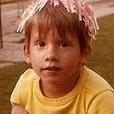
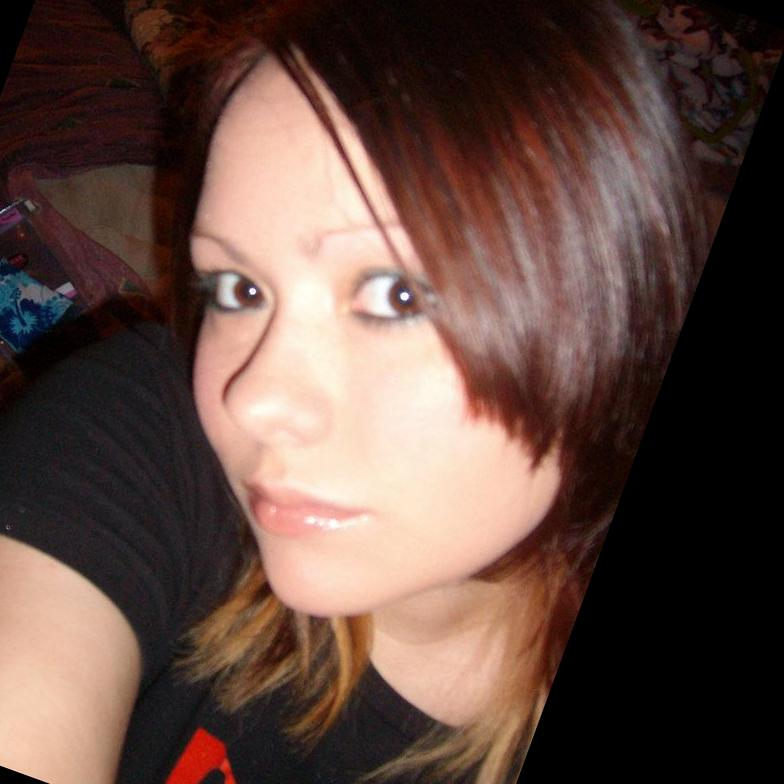
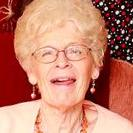
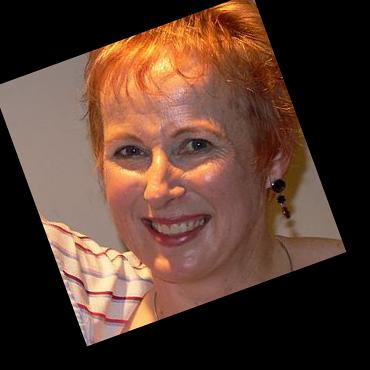
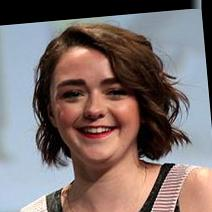
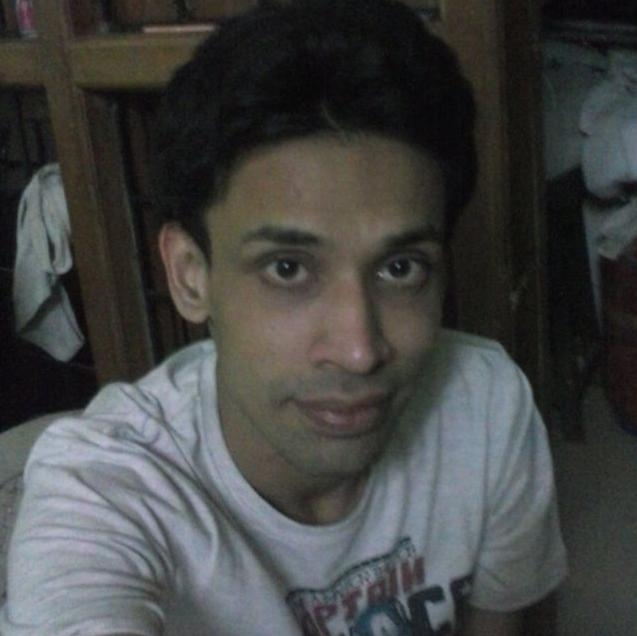
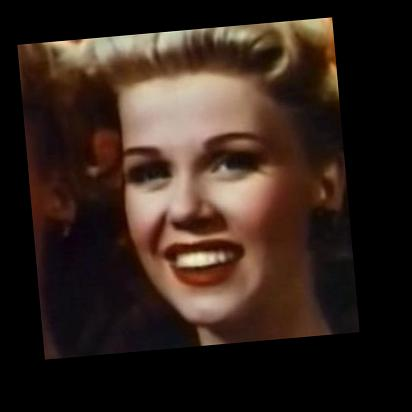
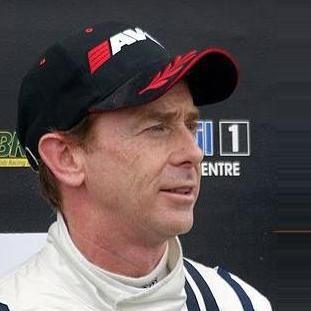
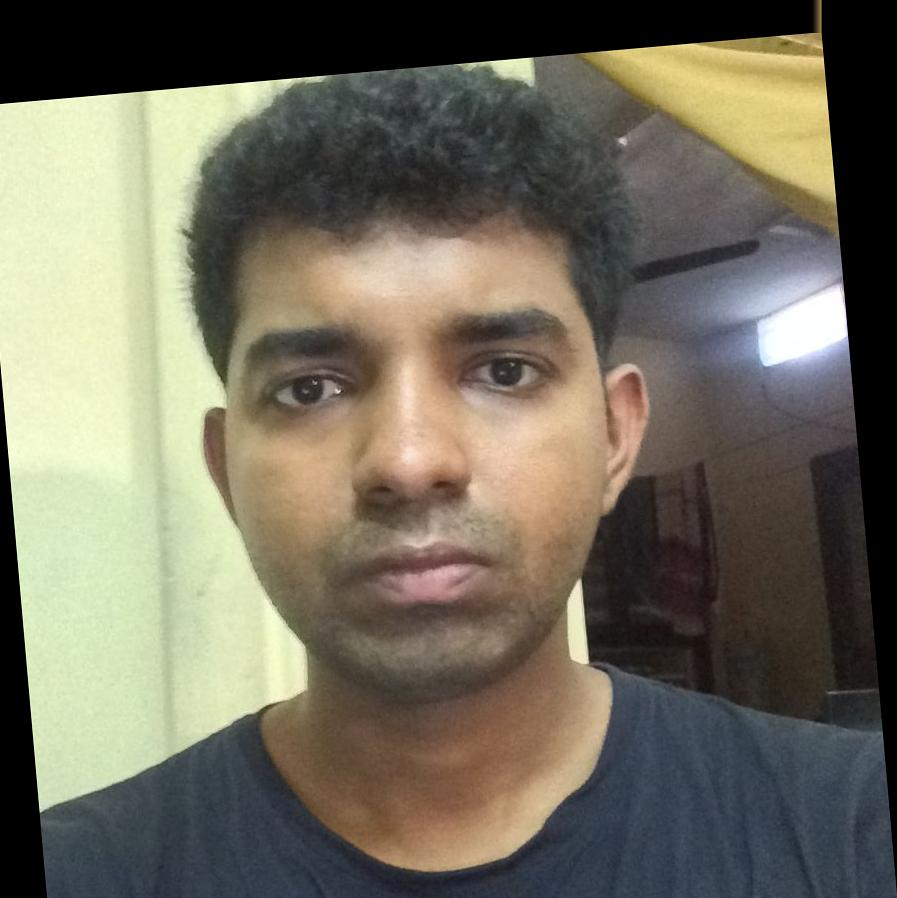
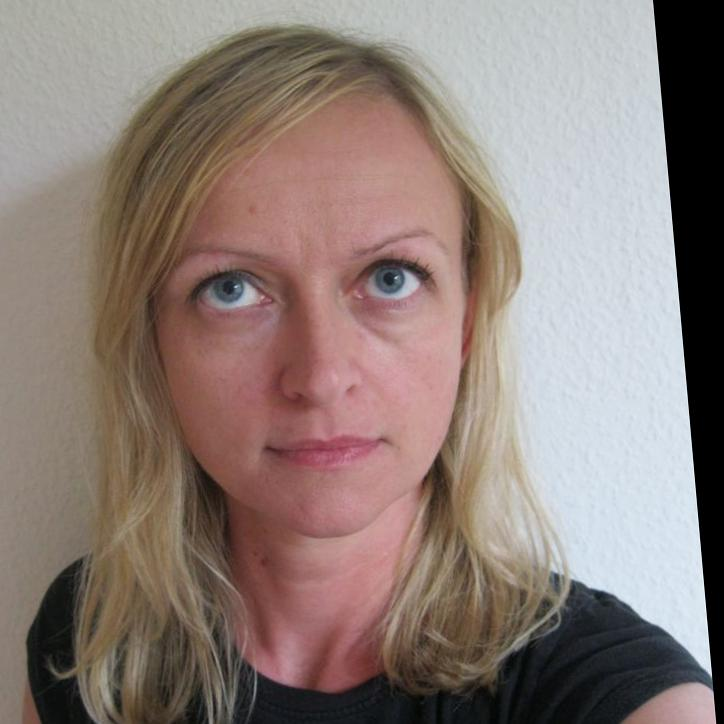
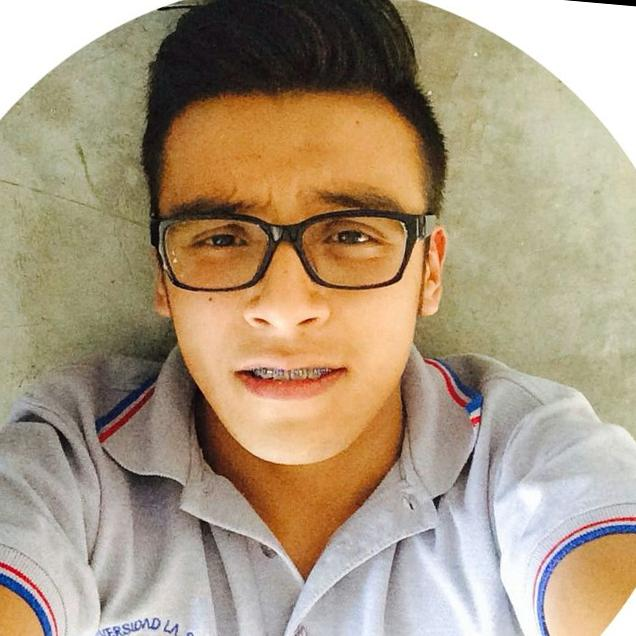
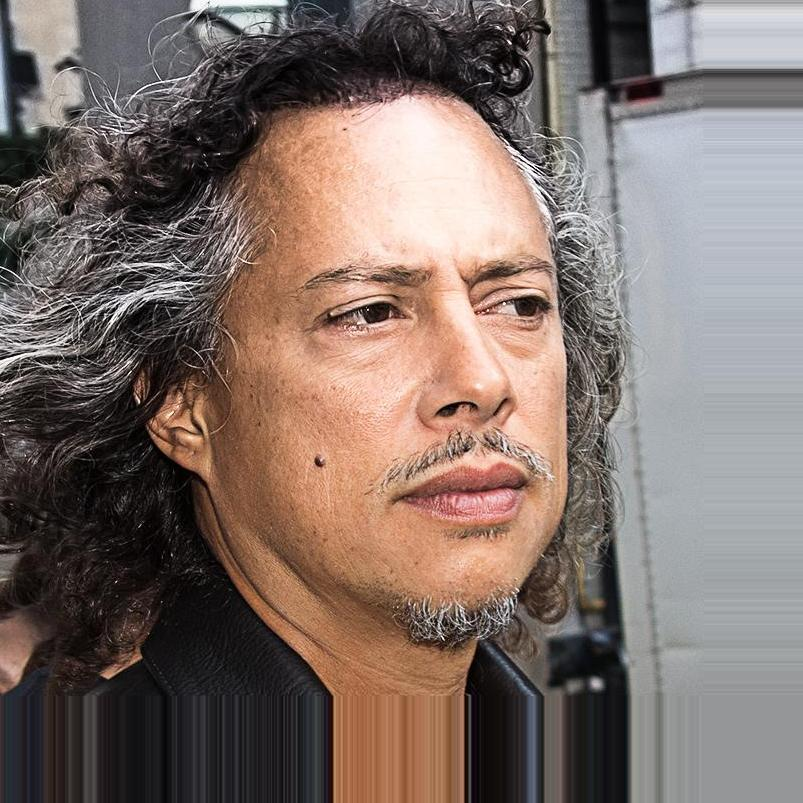
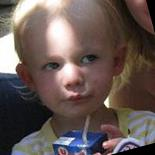
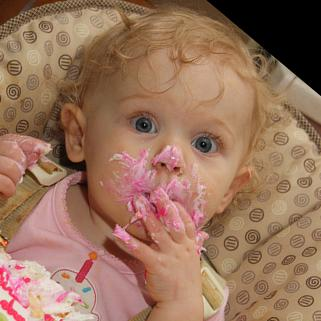
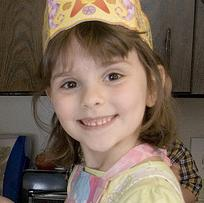
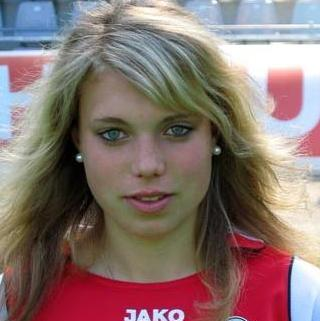
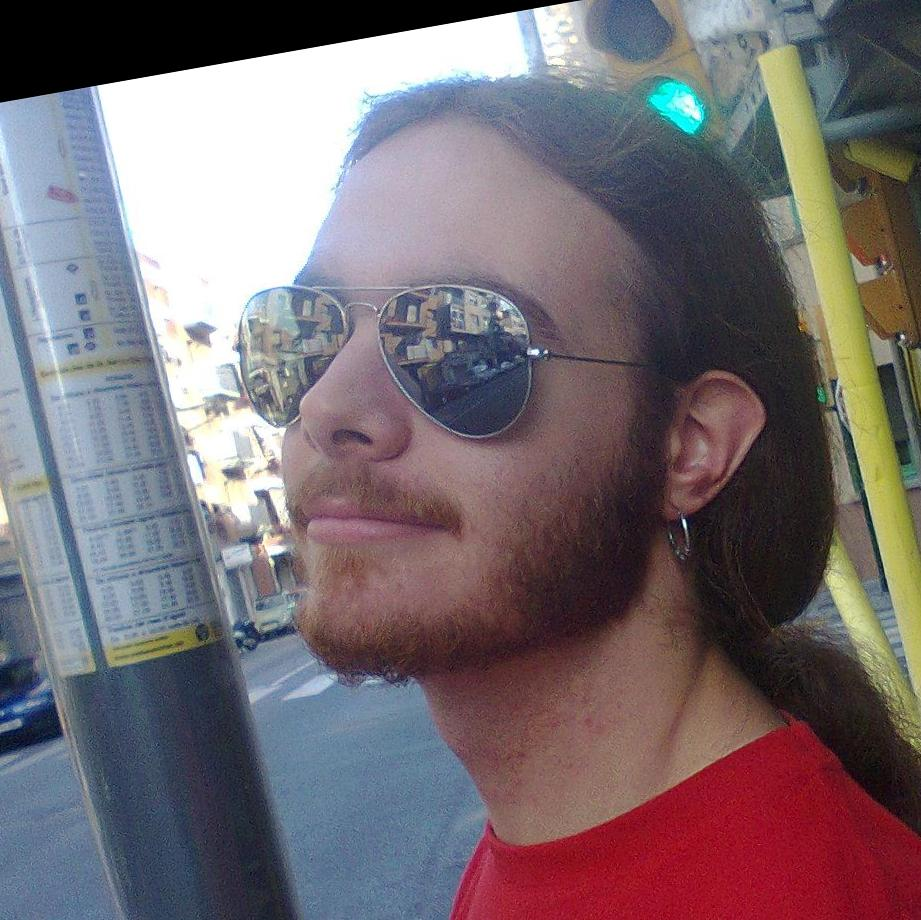
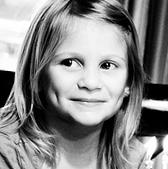
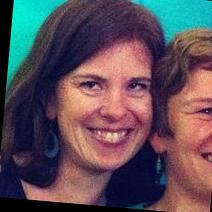
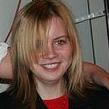
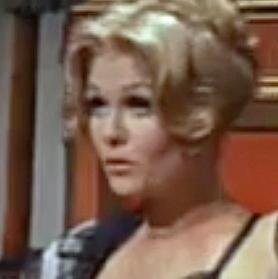
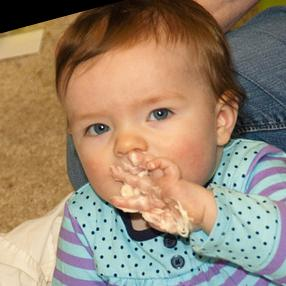
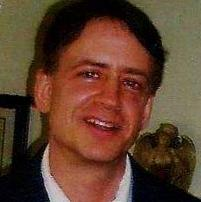
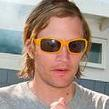
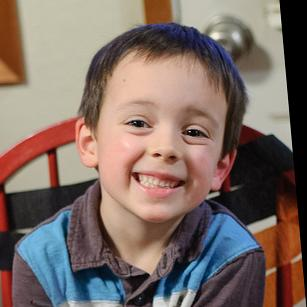
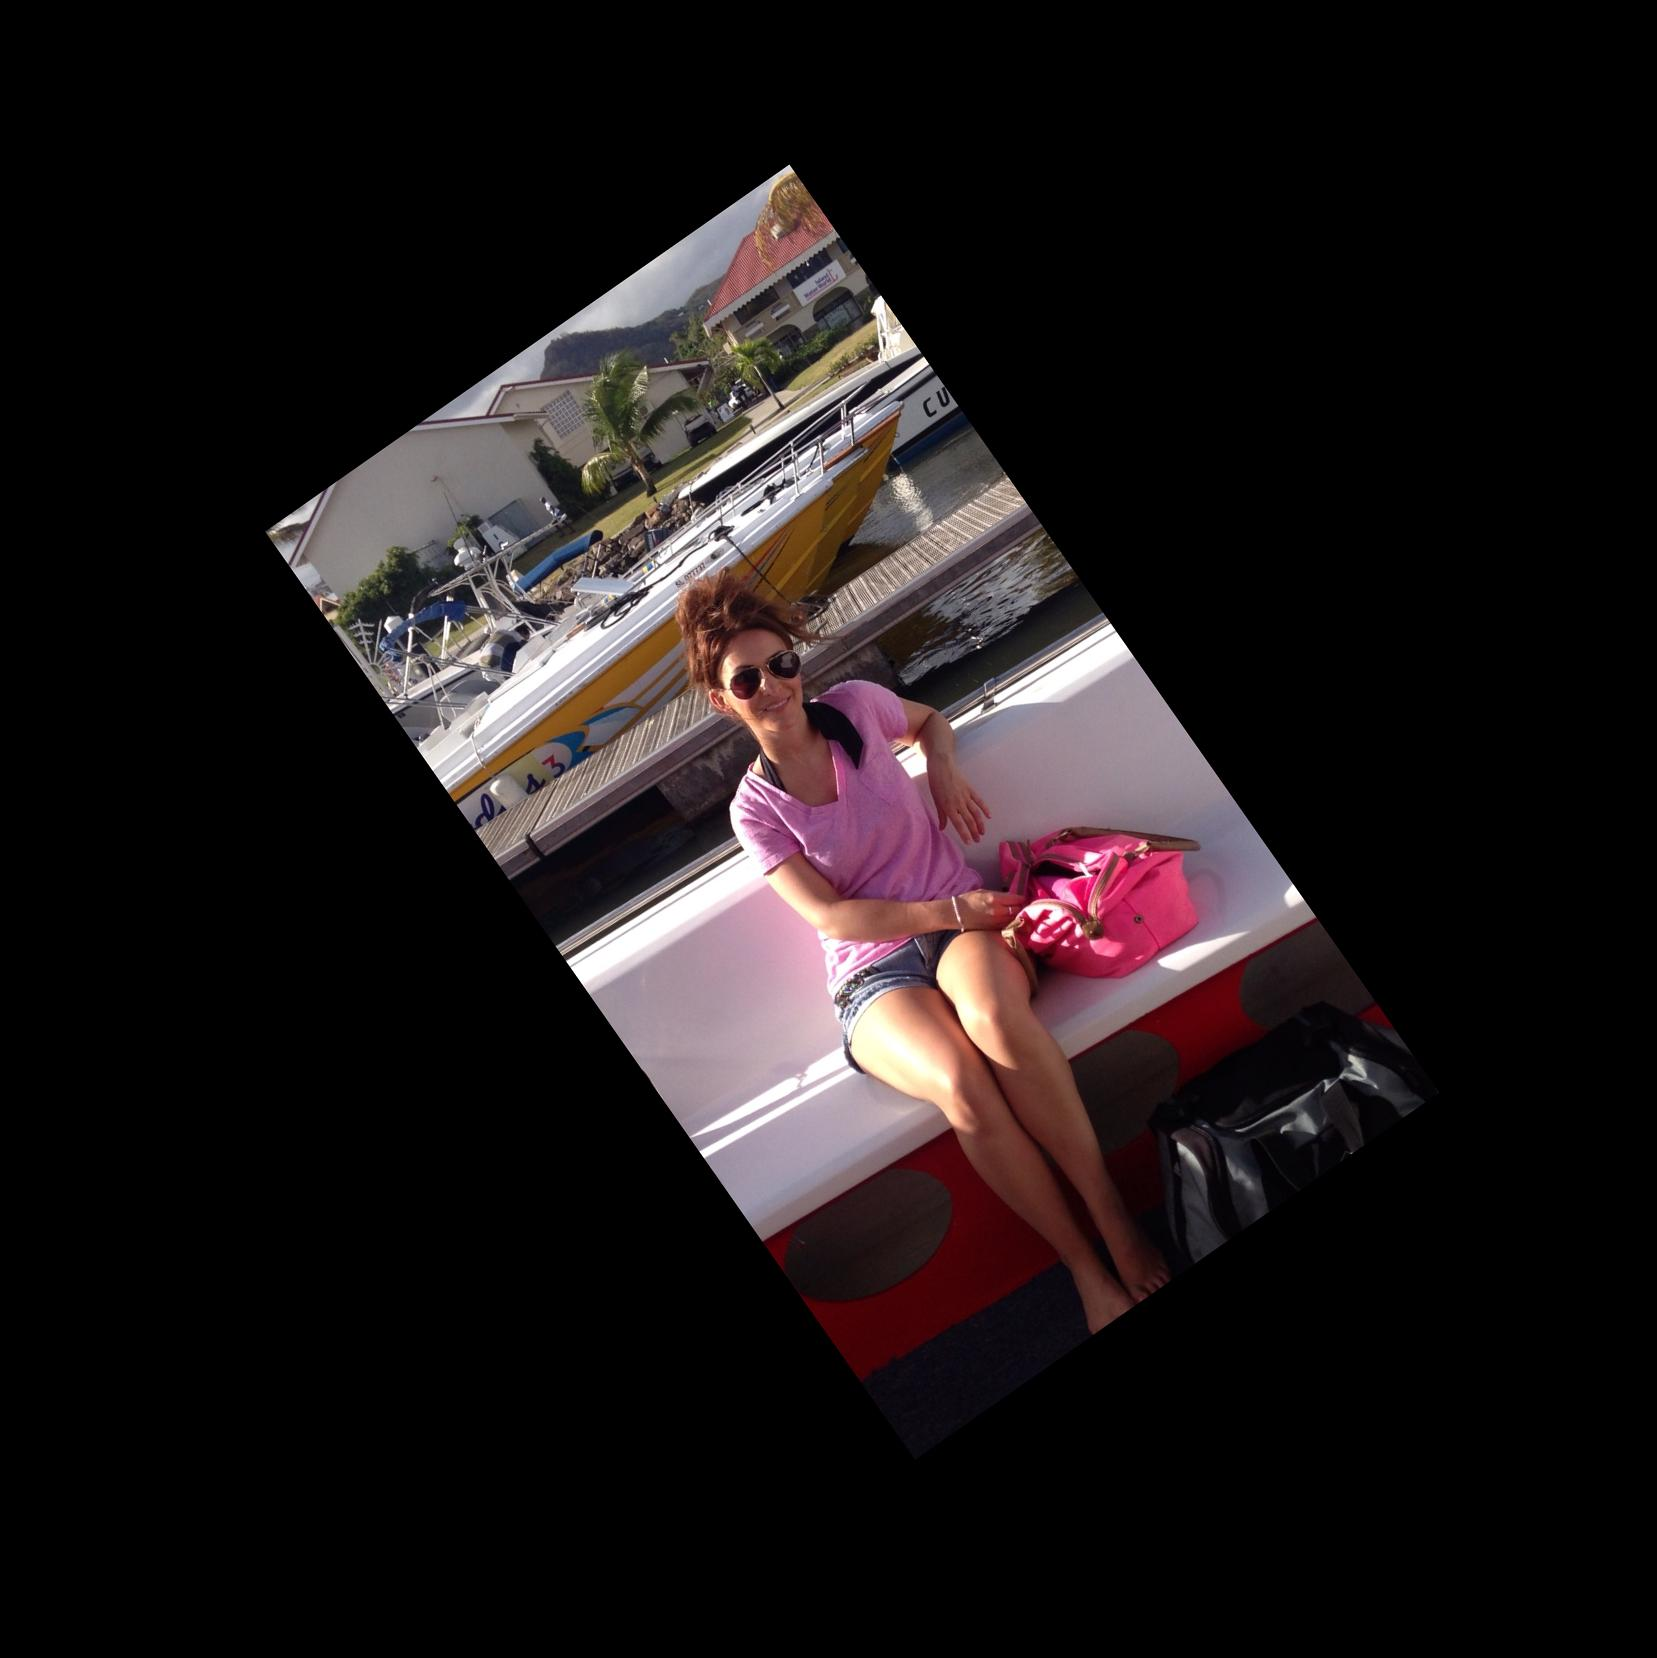
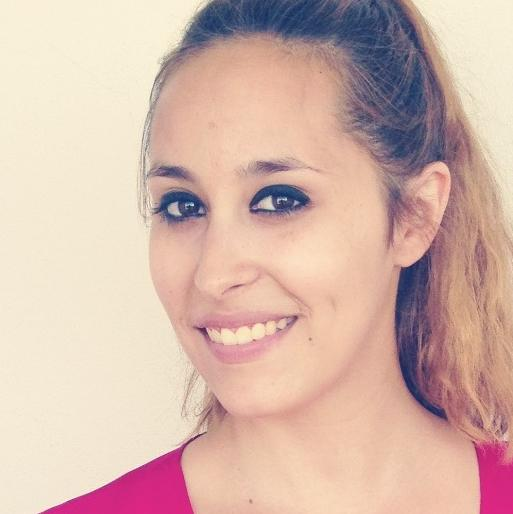
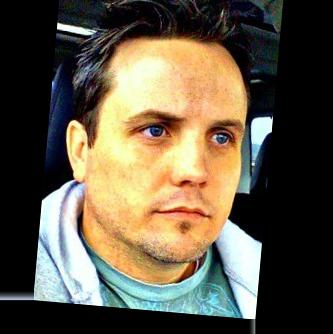
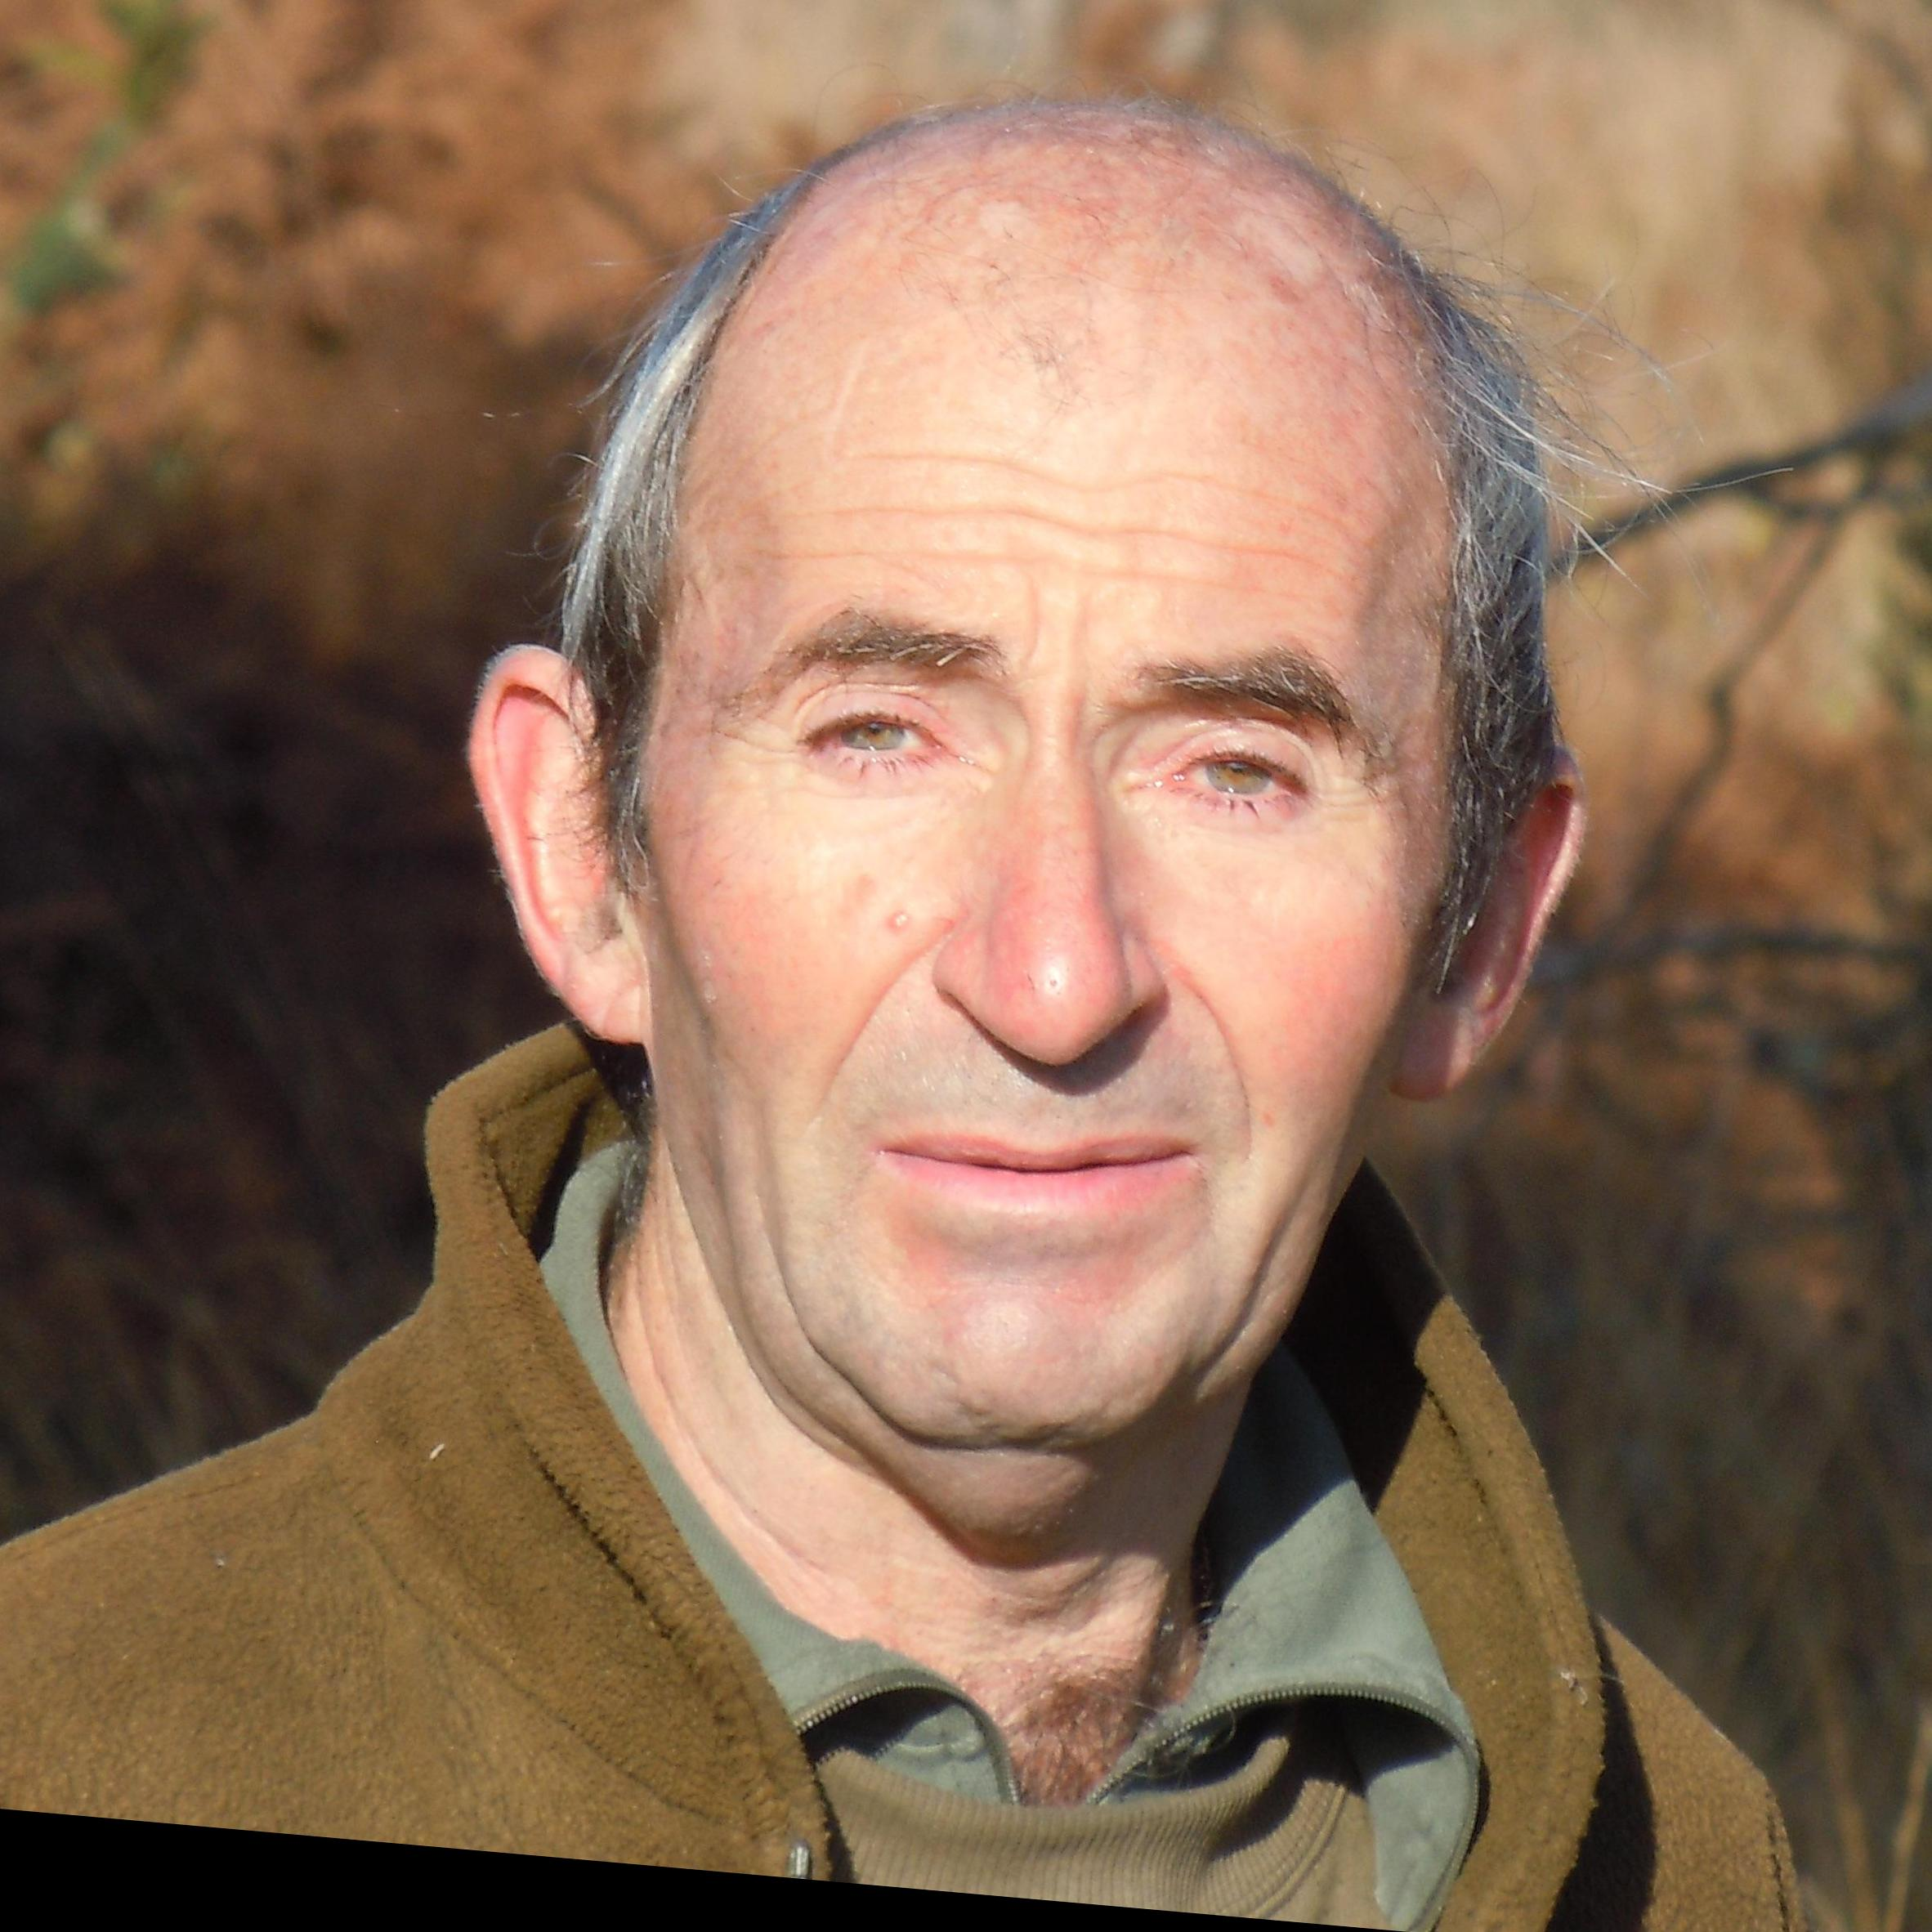
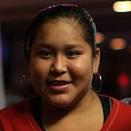
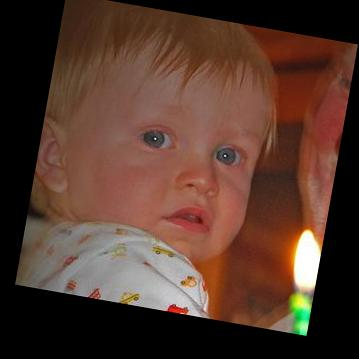
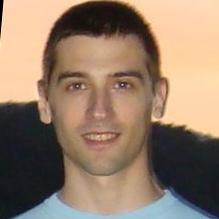
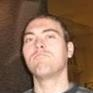
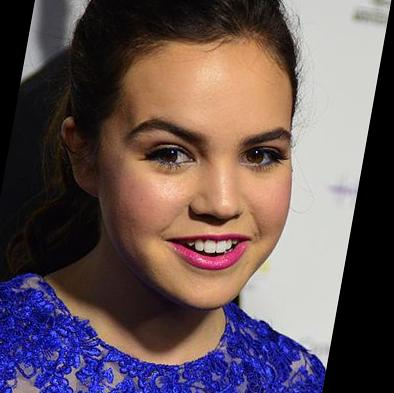
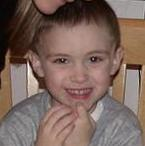
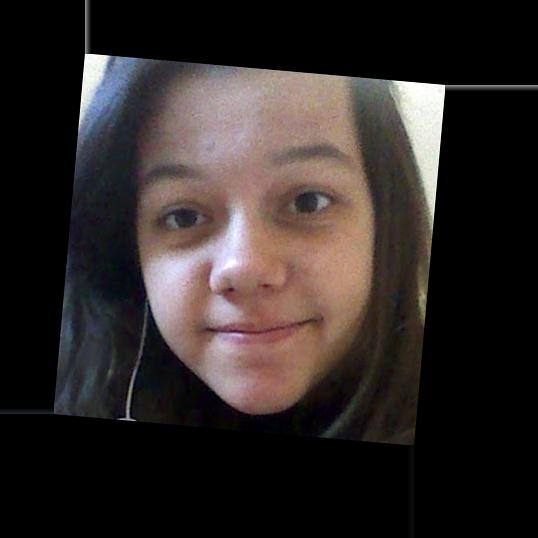
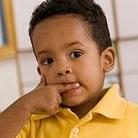
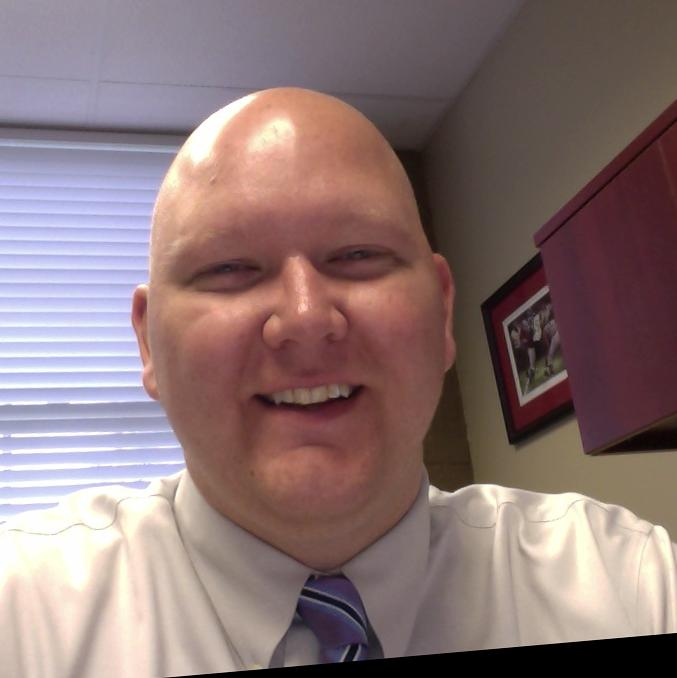
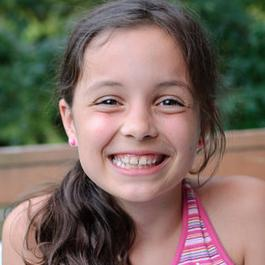
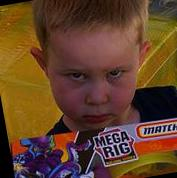
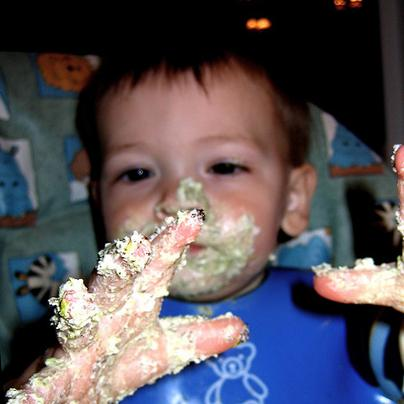
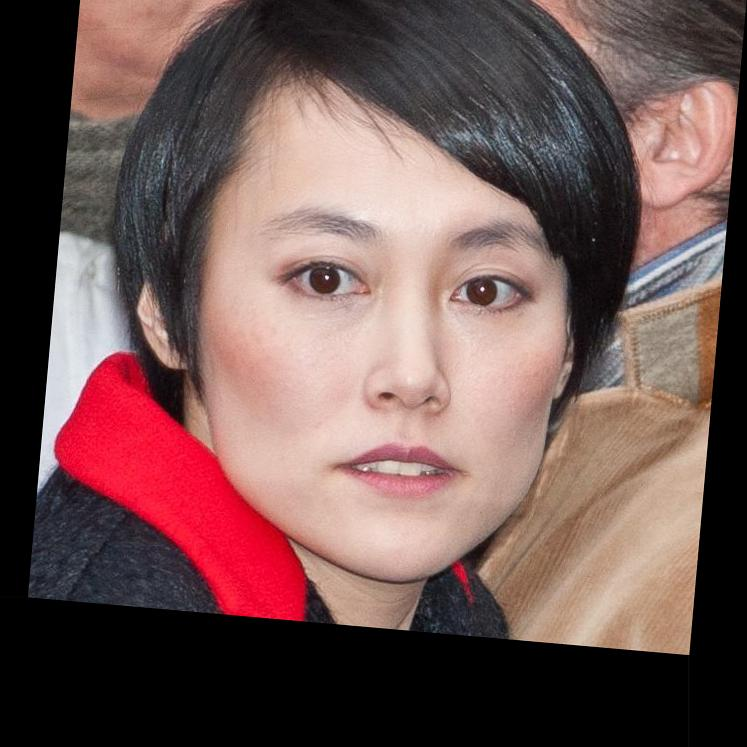
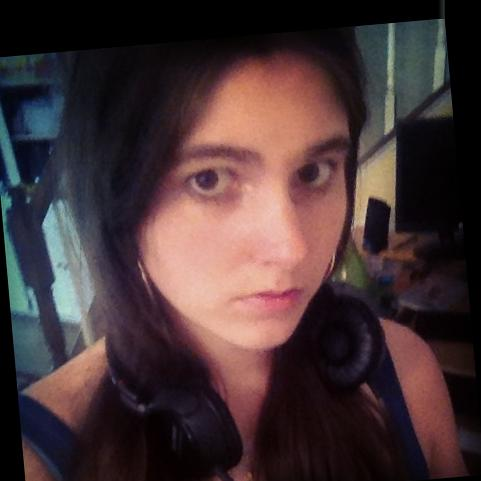
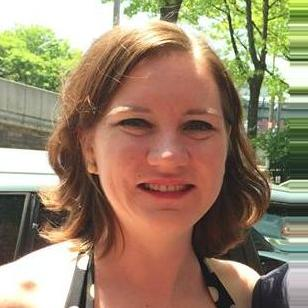
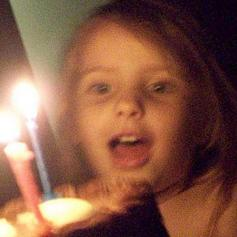
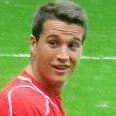
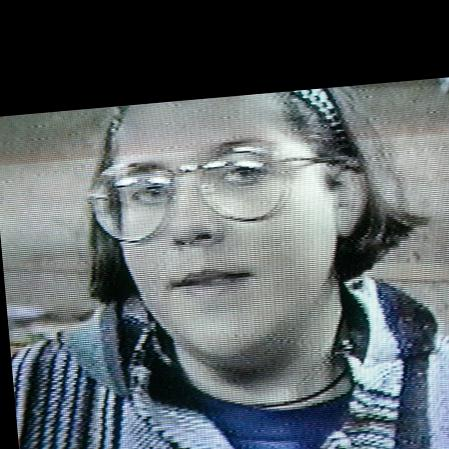
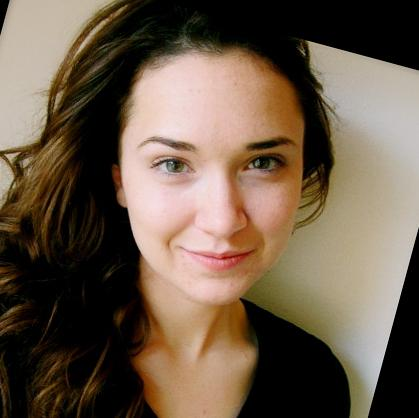
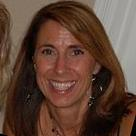
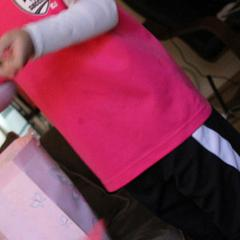
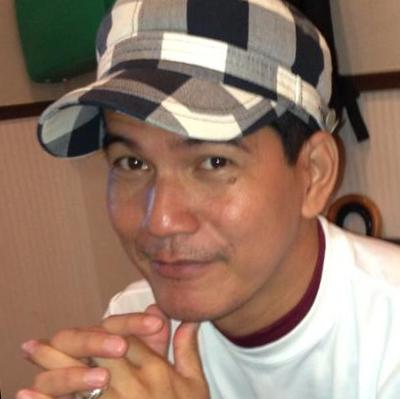
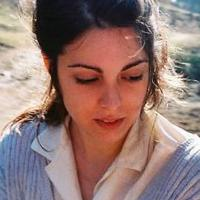
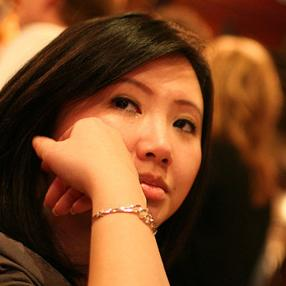
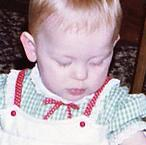
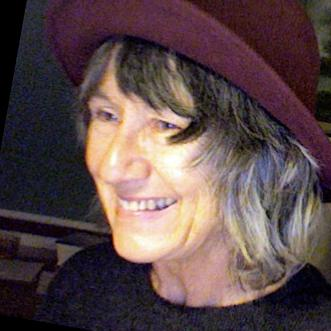
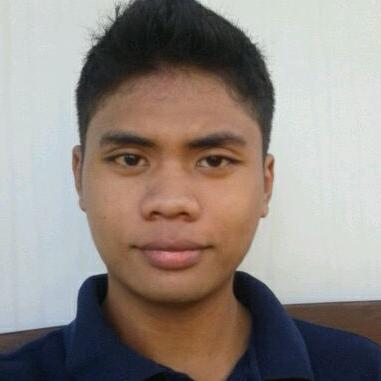
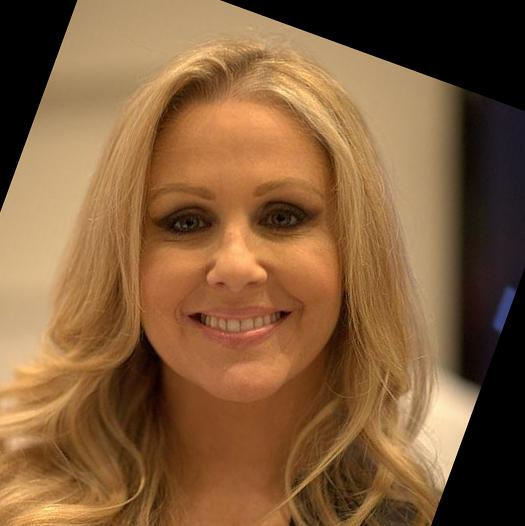
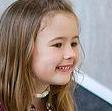
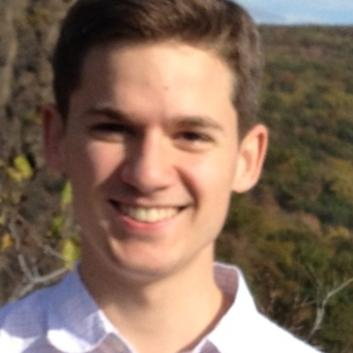
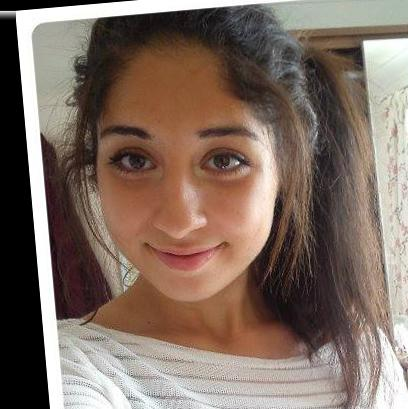
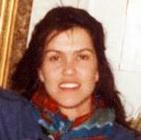
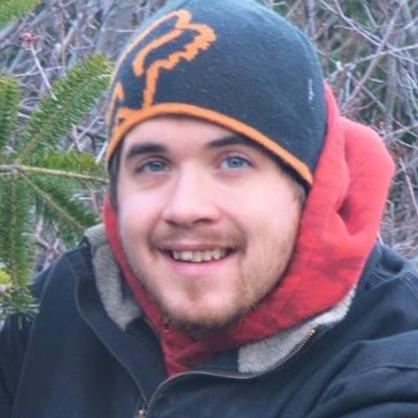
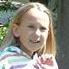
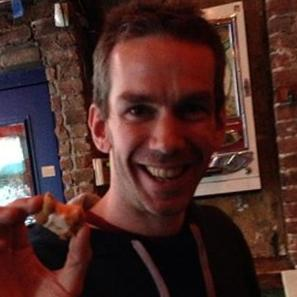
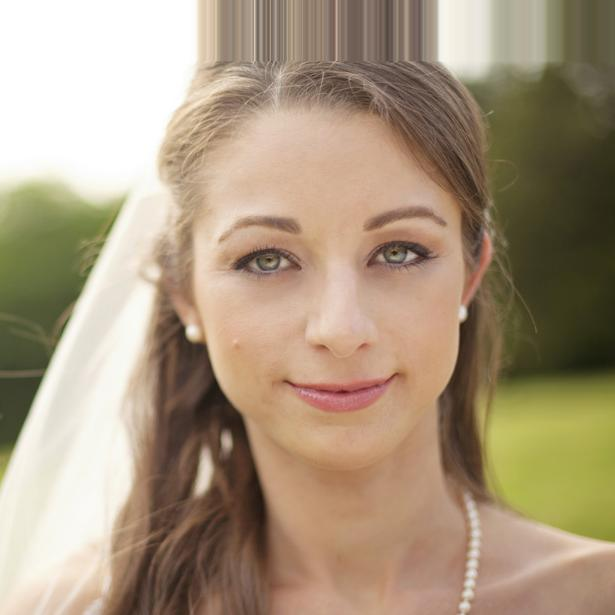
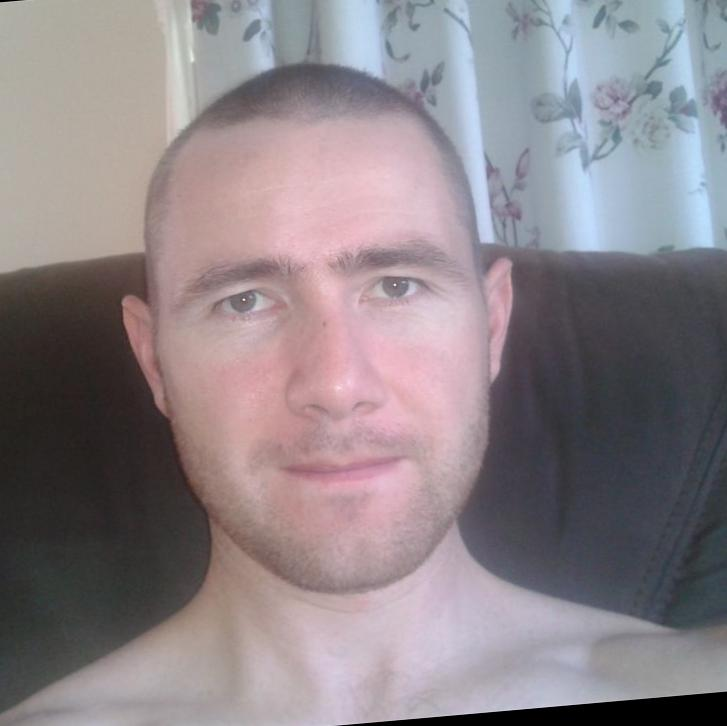
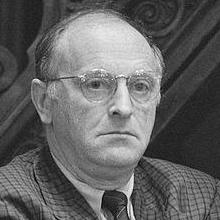
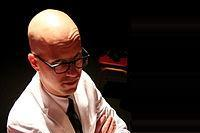
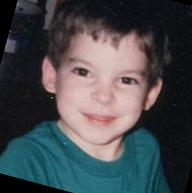
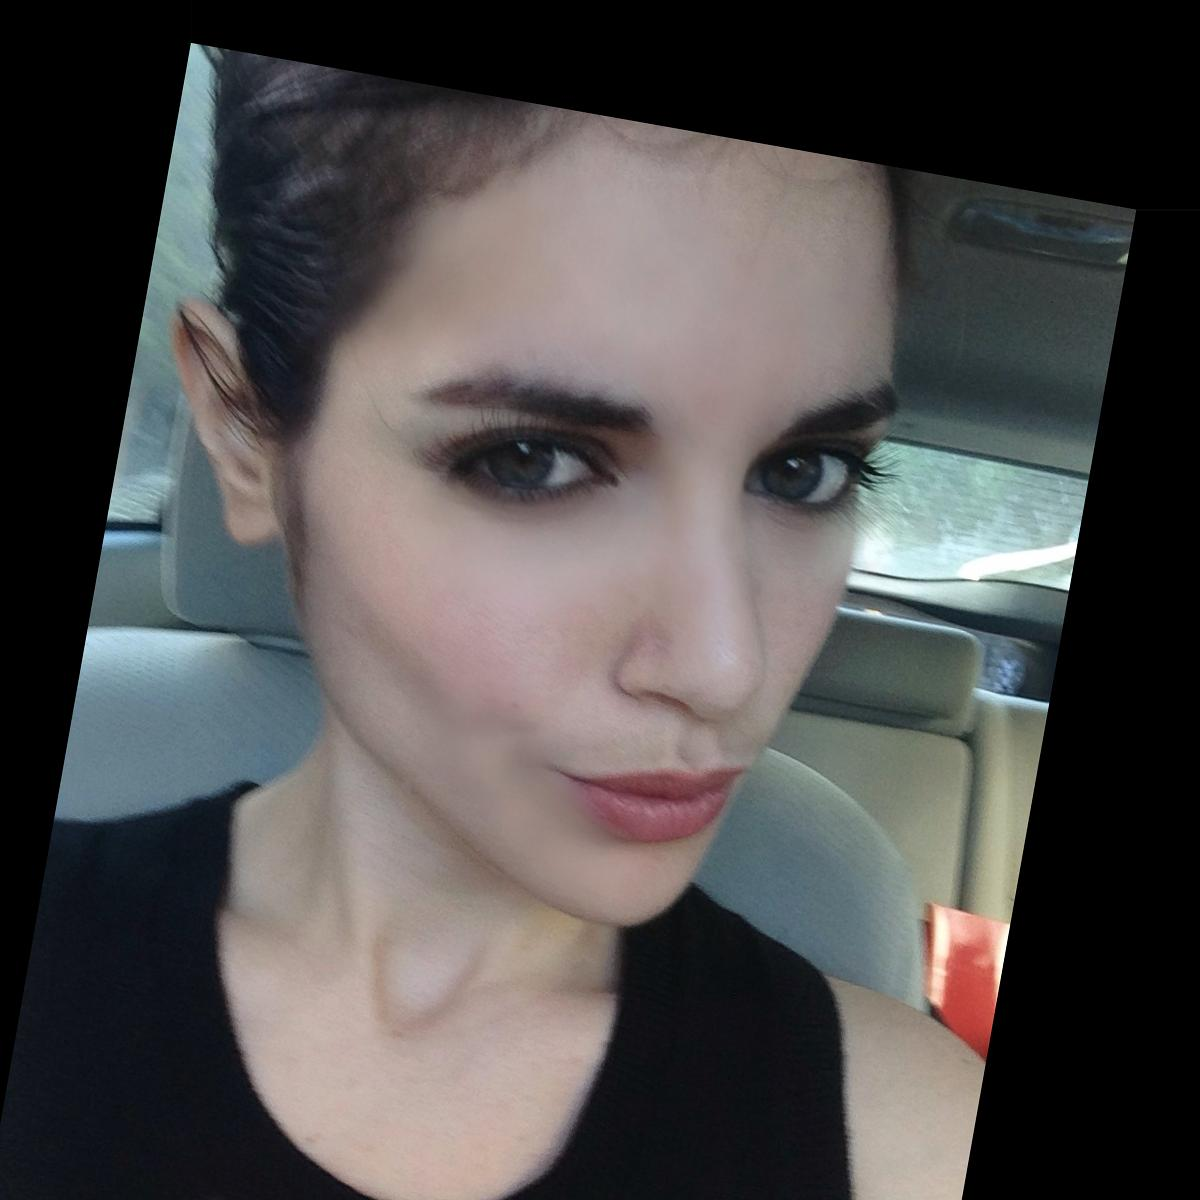
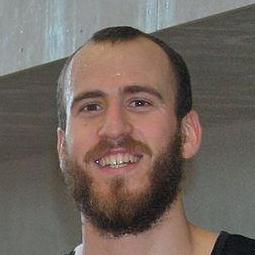
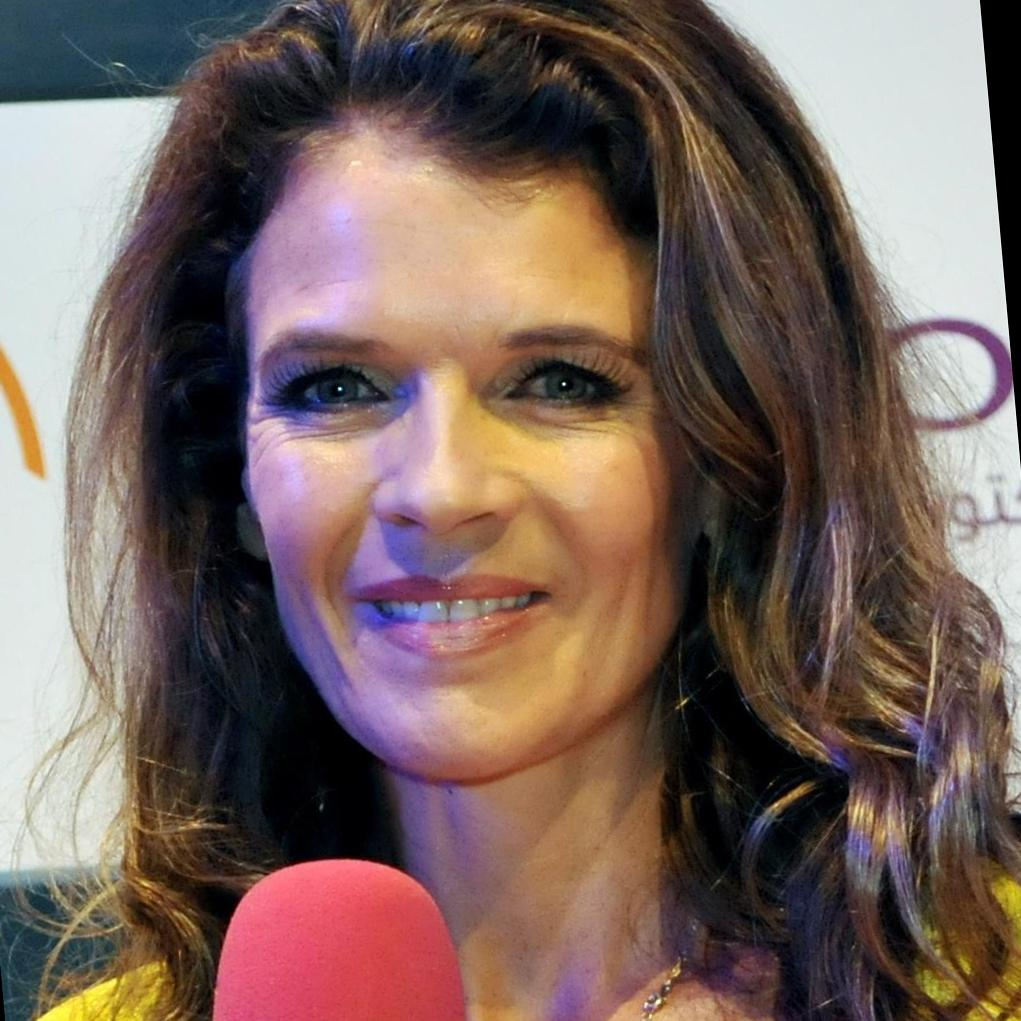
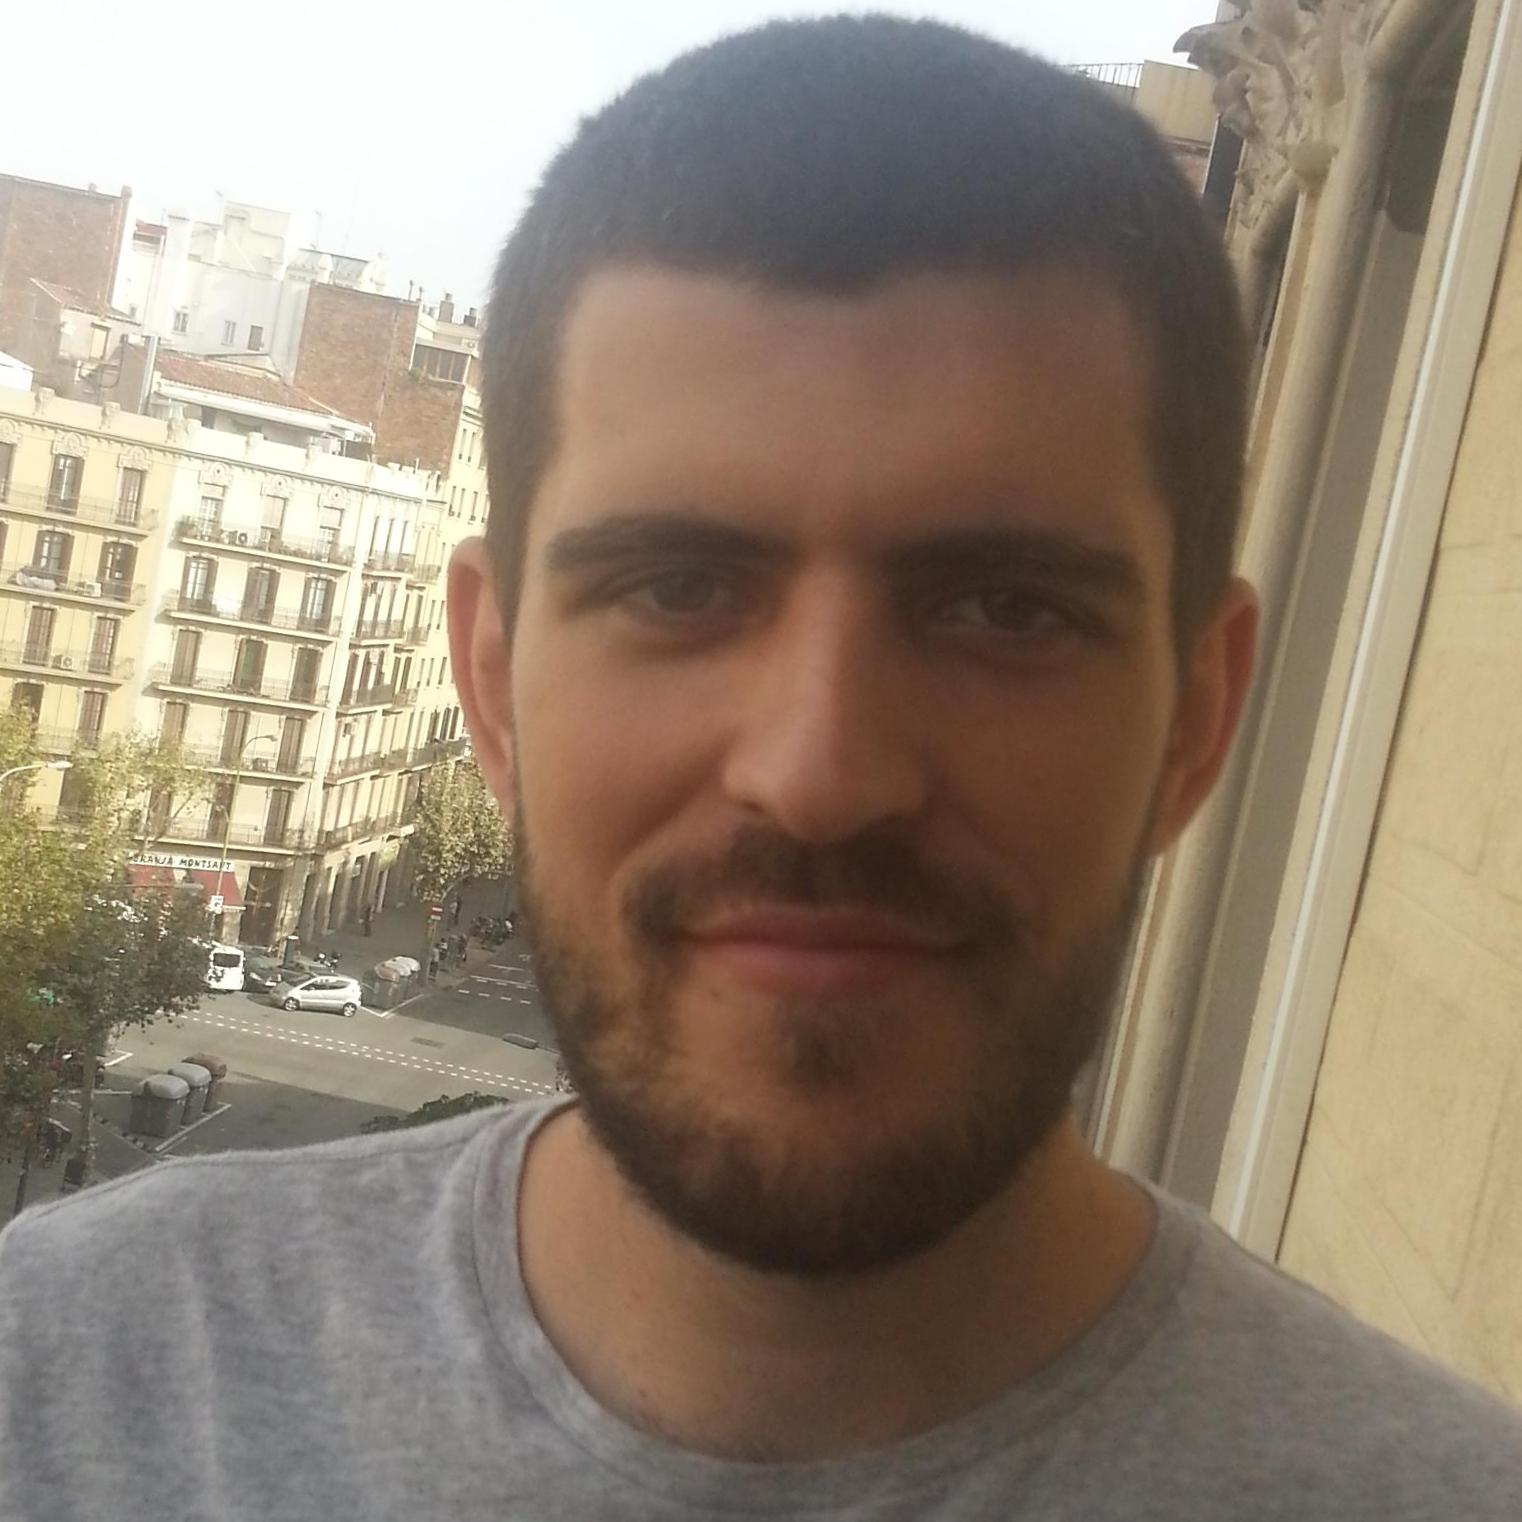
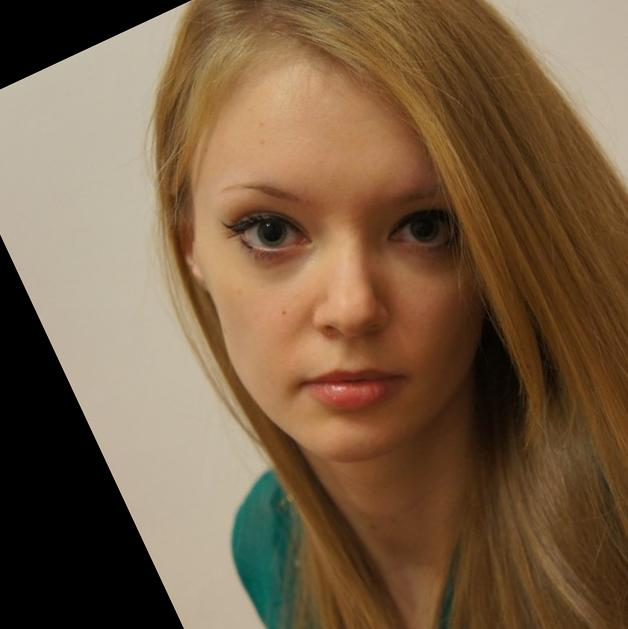
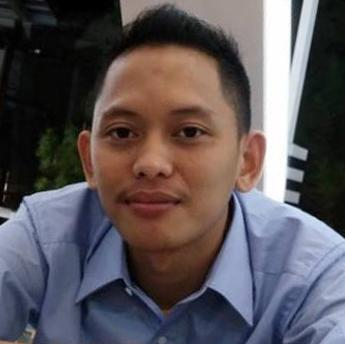
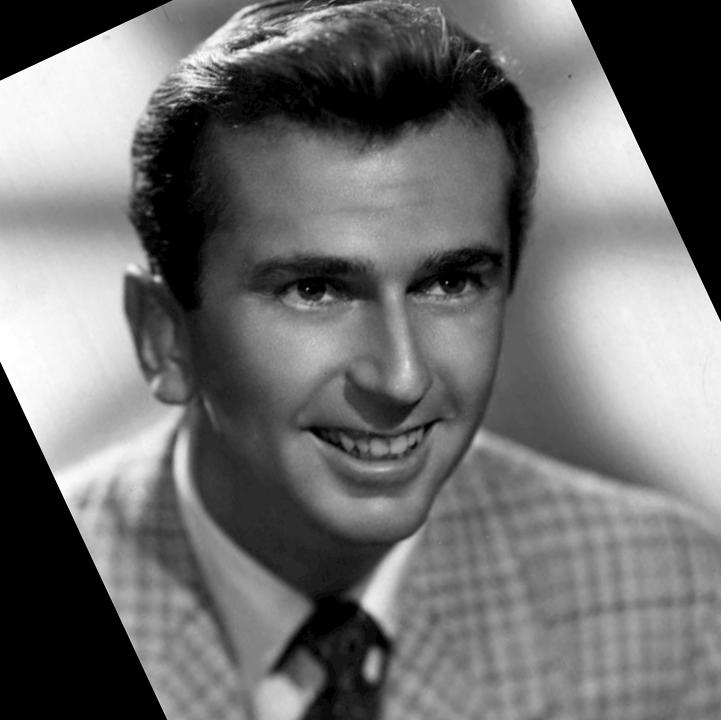
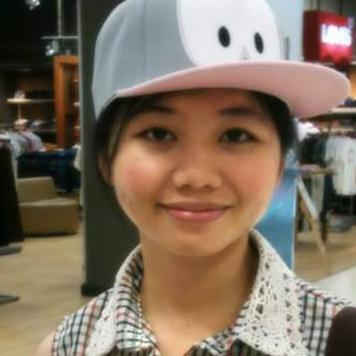
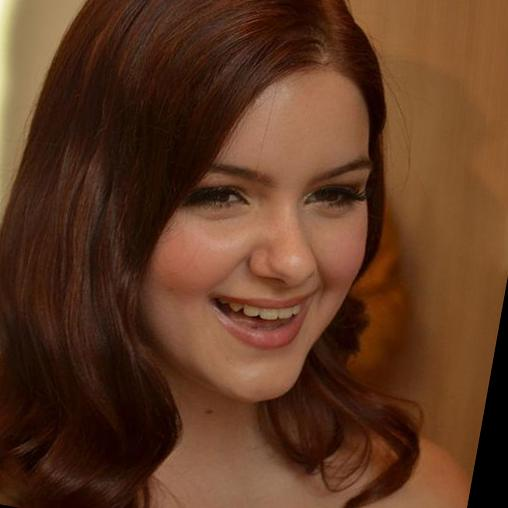
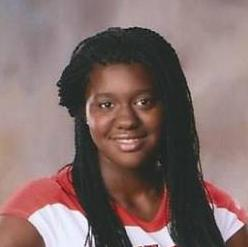
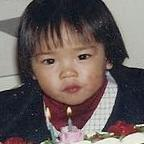

(tensor(0.1796), tensor(0.2973))

In [84]:
# Specify the paths to your images
num_images = 80
df = pd.read_csv('labels.csv')
image_paths = df.iloc[:, 0]
image_paths = get_image_paths('final_files', num_images)
real_age = df.iloc[:, 1]

#image_paths = get_image_paths('final_files', num_images)
# give some text for your pictures
texts = ["Person in age between 1 and 5", "Person in age between 6 and 10", "Person in age between 11 and 20", "Person in age between 21 and 30", "Person in age between 31 and 40", 
         "Person in age between 41 and 50",  "Person in age between 51 and 60", "Person in age between 61 and 70", "Person in age above 70"]
display_similarity(image_paths, texts, real_age)